<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#人工神经网络" data-toc-modified-id="人工神经网络-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>人工神经网络</a></span></li><li><span><a href="#创建数据集" data-toc-modified-id="创建数据集-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>创建数据集</a></span><ul class="toc-item"><li><span><a href="#创建验证码captcha" data-toc-modified-id="创建验证码captcha-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>创建验证码captcha</a></span></li><li><span><a href="#分割字母" data-toc-modified-id="分割字母-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>分割字母</a></span></li><li><span><a href="#创建训练集" data-toc-modified-id="创建训练集-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>创建训练集</a></span></li><li><span><a href="#根据抽取方法调整训练集图像" data-toc-modified-id="根据抽取方法调整训练集图像-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>根据抽取方法调整训练集图像</a></span></li></ul></li><li><span><a href="#训练和分类" data-toc-modified-id="训练和分类-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>训练和分类</a></span><ul class="toc-item"><li><span><a href="#如何确定隐藏层神经元数量？--" data-toc-modified-id="如何确定隐藏层神经元数量？---3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>如何确定隐藏层神经元数量？  </a></span></li><li><span><a href="#BP反向传播训练" data-toc-modified-id="BP反向传播训练-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>BP反向传播训练</a></span></li><li><span><a href="#构建预测器" data-toc-modified-id="构建预测器-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>构建预测器</a></span></li></ul></li></ul></div>

本章介绍如何用神经网络自动识别验证码。  
验证码的英文是CAPTCHA，是首字母缩写。  
本章包含以下内容： 
 - 神经网络
 - 创建验证码和字母的数据集
 - 用scikit-image处理图像数据
 - 神经网络库PyBrain
 - 从图像中抽取基本特征  
 - 使用神经网络进行更大规模的分类任务
 - 用后处理提升效果

# 人工神经网络

这里，我们需要自己动手，实现验证码的生成。   
生成的验证码是弱化的验证码，比不上真实的验证码。  
生成思路是，对单词使用错切变化，使用PIL库和scikit-image库。  
scikit-image能够接受PIL库导出的numpy格式的图像数据，结合两个库进行使用。

PIL库实际上在python3中是Pillow库，使用方式，仍import PIL

# 创建数据集 

## 创建验证码captcha 

In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf

In [3]:
def create_captcha(text, shear=0, size=(100,24)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"Abel-Regular.ttf", 22)
    draw.text((0,-5), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image / image.max()

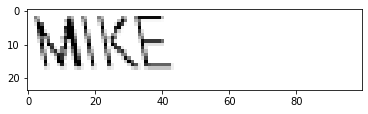

In [110]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("MIKE", shear=0.2)
plt.figure()
plt.imshow(image, cmap="Greys")
plt.show()

## 分割字母 

In [5]:
from skimage.measure import label, regionprops
def segment_image(image):
    #  label函数能够返回图像中像素值相同且又连接在一起的像素块
    labeled_image = label(image>0)
    subimages = []
    for region in regionprops(labeled_image):
        startx, starty, endx, endy = region.bbox
        subimages.append(image[startx:endx, starty:endy])
    if len(subimages)==0:
        return [image, ]
    else:
        return subimages

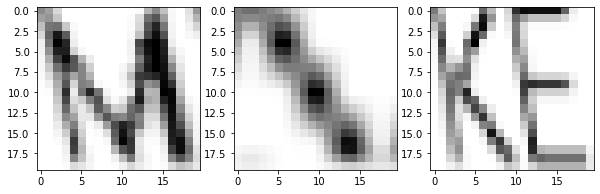

In [111]:
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages),figsize=(10,3))
for k,v in enumerate(subimages):
    axes[k].imshow(resize(v,(20,20)), cmap="Greys")

## 创建训练集 

In [7]:
# 指定随机状态值
# 创建字母表
# 指定shear错切值
from sklearn.utils import check_random_state
random_state = check_random_state(14) #  Turn seed into a np.random.RandomState instance
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05) # range() 函数只能处理整数（包括正数和负数）， np.arange()可以处理小数

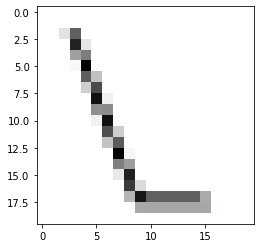

In [8]:
def generate_sample(random_state=None):
    global letters, shear_values
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear = shear, size=(20, 20)), letters.index(letter) # index 返回目标所在的位置
# test this function
image, target = generate_sample(random_state)
plt.imshow(image, cmap="Greys")


In [9]:
# 循环创建数据集
dataset, targets = zip(*(generate_sample(random_state) for i in range(3000))) # 这里需要对iterater返回的内容进行解索引，在内容前面加*
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

In [27]:
# 采用onehot编码
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0], 1))
y = y.todense() # 将矩阵转换成密级矩阵， 因为库不支持稀疏矩阵

## 根据抽取方法调整训练集图像
我们抽取图像的方法是size(20, 20)的图像，但是在验证码图像分割时，是从单词中抽取图像，可能会造成图像畸变

In [37]:
# 使用resize函数
from skimage.transform import resize
# 将得到的小图调整为20像素见方
dataset = np.array(
    [resize(segment_image(sample)[0], (20, 20)) for sample in dataset]
)
X = dataset.reshape((dataset.shape[0], dataset.shape[1]*dataset.shape[2]))
# 切分数据集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# 训练和分类 

In [38]:
# 将pybrain的数据格式引入
from pybrain.datasets import SupervisedDataSet
# training set
training = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    training.addSample(X_train[i], y_train[i])
#test set
testing = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    testing.addSample(X_test[i], y_test[i])

创建具有三层结构的神经网络：
 - 输入层：数据集有400个特征，第一层有400个神经元
 - 隐藏层
 - 输出层：输出26个类别，所以输出层有26个神经元
 
如何确定隐藏层神经元数量？  
------------
神经元数量过多，神经网络出现稀疏的特点，要训练足够多的神经元表达数据特征就会比较困难，往往会导致过拟合；  
神经元过少，每个对分类结果的影响就很很大，再加上训练不充分，就很可能拟合程度较低。

In [40]:
# 导入buildNetwork函数，指定维度，创建神经网络。
from pybrain.tools.shortcuts import buildNetwork
net = buildNetwork(X.shape[1], 100, y.shape[1], bias=True)

## BP反向传播训练


pybrain提供了backprop的一种实现方式，调用trainer类即可

In [88]:
from pybrain.supervised.trainers import BackpropTrainer
trainer = BackpropTrainer(net, training, learningrate=0.01, weightdecay=0.01)
trainer.trainEpochs(epochs = 20)
predictions = trainer.testOnClassData(dataset=testing)
from sklearn.metrics import f1_score, precision_score, recall_score
print("{0:.4f}".format(f1_score(y_test.argmax(axis=1), predictions, average="weighted")))

0.9625


## 构建预测器 

In [89]:
def predict_captcha(captcha, net, letters):
    subimages = segment_image(captcha)
    predicted_word = ''
    for subimage in subimages:
        subimage = resize(subimage, (20, 20))
        outputs = net.activate(subimage.flatten())
        prediction = np.argmax(outputs)
        predicted_word += letters[prediction]
    return predicted_word

In [99]:
def test_prediction(word, net, letters, shear=0.2):
    captcha = create_captcha(word, shear=0.2)
    prediction = predict_captcha(captcha, net, letters)
    return word == prediction, word, prediction

In [106]:
test_prediction("MIKE", net , letters, shear=0.2)

(False, 'MIKE', 'MIF')